In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

src = np.float32(
    [[0, 720],
    [1280, 720],
    [542, 464],
    [738, 464]])

#src = np.float32(
#    [[0, 720],
#    [1280, 720],
#    [510, 480],
#    [770, 480]]

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])

m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)

In [2]:
def abs_sobel_thres(img, orient='x', sobel_thresh=(20, 100)):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thres(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thres(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

def HLS_thres(img, HLS_thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > HLS_thresh[0]) & (s_channel <= HLS_thresh[1])] = 1
    return binary_output

def HSV_thres(img, HSV_thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > HSV_thresh[0]) & (v_channel <= HSV_thresh[1])] = 1
    return binary_output

def yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([0,100,100])
    upper_yellow = np.array([50,255,255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask/255
    return mask

def white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_white = np.array([18,0,170])
    upper_white = np.array([255,80,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    mask = mask/255
    return mask
    

In [3]:
with open('calibration_data/calibration_matrices.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
print(mtx)
print()
print(dist)

[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]


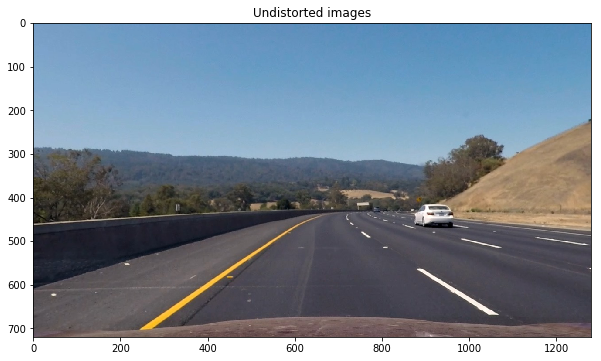

In [4]:
image_file = 'test_images/test3.jpg'
image = cv2.imread(image_file)
image = cv2.resize(image, (1280, 720)) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(image, cmap="gray")
plt.title('Undistorted images')

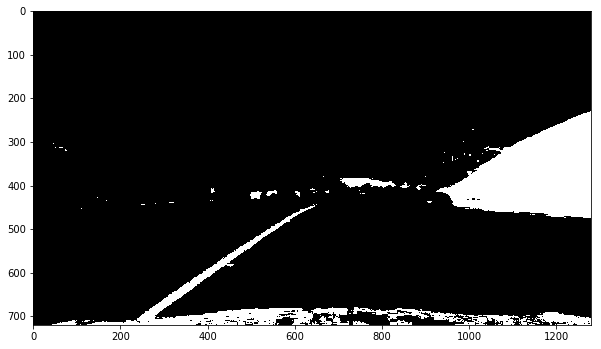

In [5]:
def yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([0,50,100])
    upper_yellow = np.array([50,255,255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask/255
    return mask
    
yellow_mask = yellow(image)
plt.imshow(yellow_mask, cmap="gray")

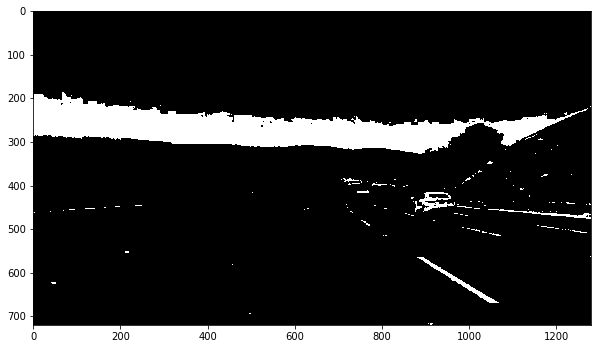

In [6]:
def white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_white = np.array([5,0,170])
    upper_white = np.array([255,80,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    mask = mask/255
    return mask

white_mask = white(image)
plt.imshow(white_mask, cmap="gray")

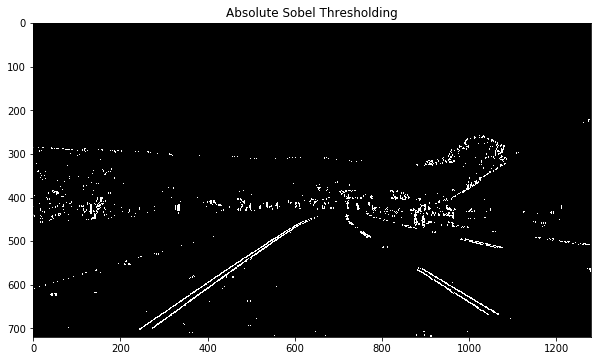

In [7]:
def update_sobel(x_min,x_max):
    abs_sobel_bin = abs_sobel_thres(image,orient='x',sobel_thresh=(x_min, x_max))
    plt.imshow(abs_sobel_bin, cmap="gray")
    plt.title('Absolute Sobel Thresholding')

interact(update_sobel, 
         x_min=widgets.IntSlider(min=0,max=255,step=1,value=30),
         x_max=widgets.IntSlider(min=0,max=255,step=1,value=255));

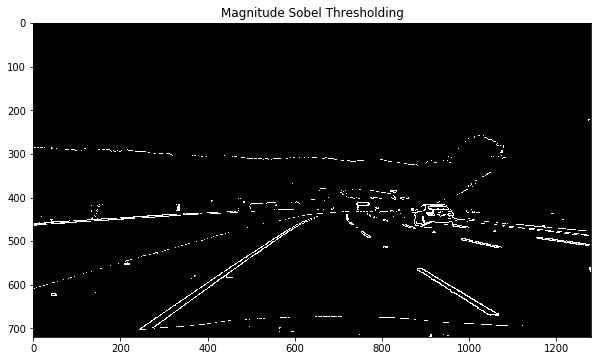

In [8]:
def update_magnitude(m_min,m_max):
    mag_bin = mag_thres(image,sobel_kernel=3, mag_thresh=(m_min, m_max))
    plt.imshow(mag_bin, cmap="gray")
    plt.title('Magnitude Sobel Thresholding')

interact(update_magnitude, 
         m_min=widgets.IntSlider(min=0,max=255,step=1,value=60),
         m_max=widgets.IntSlider(min=0,max=255,step=1,value=255));

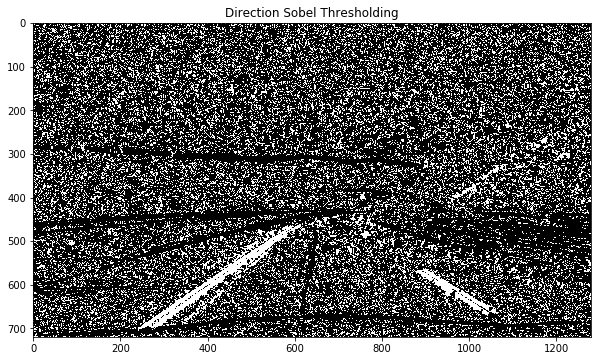

In [9]:
def update_direction(d_min,d_max):
    dir_bin = dir_thres(image,sobel_kernel=15, dir_thresh=(d_min, d_max))
    plt.imshow(dir_bin, cmap="gray")
    plt.title('Direction Sobel Thresholding')

interact(update_direction, 
         d_min=widgets.FloatSlider(min=0,max=np.pi,step=0.001,value=0.7),
         d_max=widgets.FloatSlider(min=0,max=np.pi,step=0.001,value=1.1));

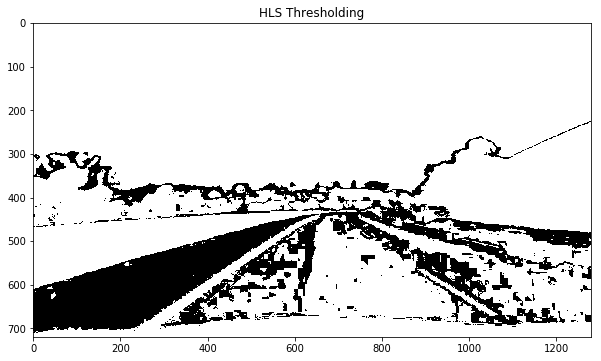

In [10]:
def update_HLS(h_min,h_max):
    hls_bin = HLS_thres(image, HLS_thresh=(h_min, h_max))
    plt.imshow(hls_bin, cmap="gray")
    plt.title('HLS Thresholding')

interact(update_HLS, 
         h_min=widgets.IntSlider(min=0,max=255,step=1,value=15),
         h_max=widgets.IntSlider(min=0,max=255,step=1,value=255));

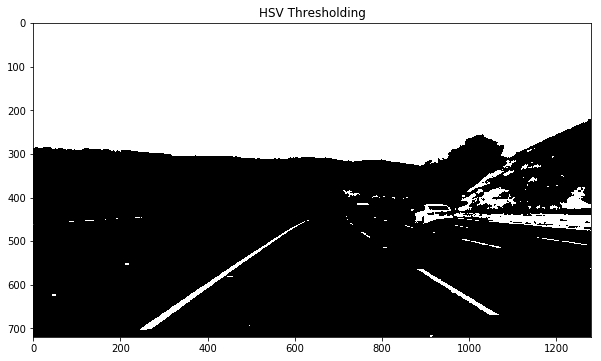

In [11]:
def update_HSV(hmin,hmax):
    hsv_bin = HSV_thres(image, HSV_thresh=(hmin, hmax))
    plt.imshow(hsv_bin, cmap="gray")
    plt.title('HSV Thresholding')

interact(update_HSV, 
         hmin=widgets.IntSlider(min=0,max=255,step=1,value=175),
         hmax=widgets.IntSlider(min=0,max=255,step=1,value=255));

In [12]:
def combined_thresh(img):
    abs_bin = abs_sobel_thres(img, orient='x', sobel_thresh=(60, 255))
    mag_bin = mag_thres(img, sobel_kernel=3, mag_thresh=(60, 255))
    dir_bin = dir_thres(img, sobel_kernel=15, dir_thresh=(0.7, 1.1))
    hls_bin = HLS_thres(img, HLS_thresh=(12, 255))
    hsv_bin = HSV_thres(img, HSV_thresh=(170, 255))
    yellow_bin = yellow(img)
    white_bin= white(img)
    combined = np.zeros_like(dir_bin)
    #combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1)) ] = 1
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1)) | ((yellow_bin == 1)|(white_bin == 1))] = 1
    #combined[((yellow_bin == 1)|(white_bin == 1))] = 1

    return combined

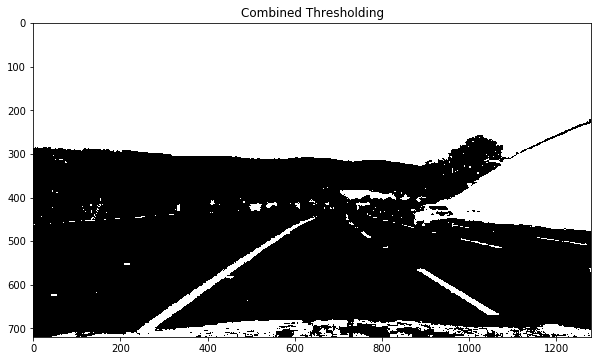

In [13]:
binary = combined_thresh(image)
plt.imshow(binary, cmap="gray")
plt.title('Combined Thresholding')

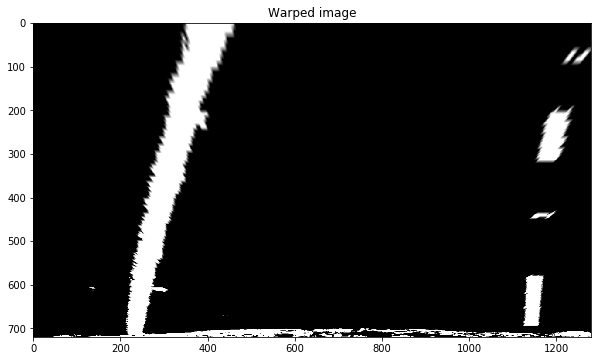

In [14]:
warped = cv2.warpPerspective(binary, m, (binary.shape[1], binary.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")
plt.title('Warped image')